In [ ]:
## Convolutional Neural Network for Predicting Badminton Shots in Still Images

In [62]:
# Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [63]:
# Modify the dataset class to return a single label
class BadmintonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        print("Columns in the CSV file:")
        print(self.annotations.columns)
        
        # Identify shot type columns (excluding 'filename')
        self.classes = [col for col in self.annotations.columns if col != 'filename']
        
        print("\nIdentified shot type columns:")
        print(self.classes)

        # Print sample data
        print("\nSample data (first 5 rows):")
        print(self.annotations.head())

        # Print data types of columns
        print("\nData types of columns:")
        print(self.annotations.dtypes)
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]  # 'filename' column
        img_path = os.path.join(self.img_dir, img_name)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
        
        image = Image.open(img_path).convert("RGB")
        
        # Get the index of the correct class (1 in the one-hot encoding)
        label = torch.tensor(self.annotations.iloc[index][self.classes].values.astype(np.float32))
        label = torch.argmax(label).item()
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

Columns in the CSV file:
Index(['filename', ' Clear Shot', ' Lift shot', ' Serve', ' Smash Shot'], dtype='object')

Identified shot type columns:
[' Clear Shot', ' Lift shot', ' Serve', ' Smash Shot']

Sample data (first 5 rows):
                                            filename   Clear Shot   Lift shot  \
0  SAIT_D2_1_321_jpg.rf.43f6d2c31e7648a1d38f4f0a3...            0           0   
1  SAIT_D2_2_276_jpg.rf.078d95f2eb914dfc59961f095...            0           1   
2  SAIT_D2_2_563_jpg.rf.45e6ea0a3949a0064a9d00d51...            0           1   
3  SAIT_D2_4_48_jpg.rf.15a2248da0998628738a7cf939...            0           0   
4  SAIT_D2_2_25_jpg.rf.3afb88e1c92a0b5137f0b154b5...            0           1   

    Serve   Smash Shot  
0       0            1  
1       0            0  
2       0            0  
3       1            0  
4       0            0  

Data types of columns:
filename       object
 Clear Shot     int64
 Lift shot      int64
 Serve          int64
 Smash Shot     int64

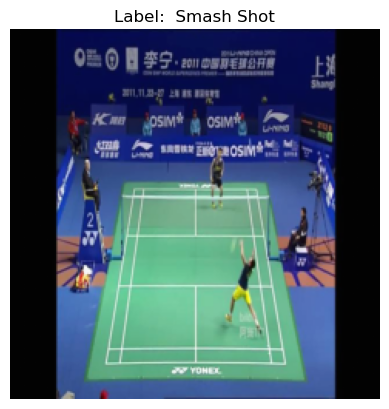

First image displayed.


In [64]:
# Data Transforms: Reduce dimensions
data_transforms = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Data
dataset = BadmintonDataset(csv_file='filtered_classes.csv', img_dir='images', transform=data_transforms)
    
# Function to display the first image with its labels
def display_first_image(dataset):
    image, label = dataset[0]
    image = image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
    image = image.clip(0, 1)  # Clip values to [0, 1] range

    plt.imshow(image)
    title = f"Label: {dataset.classes[label]}"
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first image
display_first_image(dataset)
print("First image displayed.")

In [65]:
# Split the dataset
train_size = int(0.86 * len(dataset))
val_size = int(0.09 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # initial batch size 32, changed to 16
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [66]:
class BadmintonCNN(nn.Module):
    def __init__(self, num_classes):
        super(BadmintonCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
            # No activation function here; we'll use CrossEntropyLoss which includes LogSoftmax
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [67]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {running_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

In [68]:
# Main execution
#num_classes = len(dataset.classes)
#model = BadmintonCNN(num_classes).to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

#train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

num_classes = len(dataset.classes)
model = BadmintonCNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch [1/10], Training Loss: 1.2494, Validation Loss: 1.2295, Validation Accuracy: 39.85%
Epoch [2/10], Training Loss: 1.1512, Validation Loss: 1.1435, Validation Accuracy: 46.62%
Epoch [3/10], Training Loss: 1.1096, Validation Loss: 1.0850, Validation Accuracy: 49.62%
Epoch [4/10], Training Loss: 1.0880, Validation Loss: 1.0587, Validation Accuracy: 49.62%
Epoch [5/10], Training Loss: 1.0712, Validation Loss: 1.0757, Validation Accuracy: 49.62%
Epoch [6/10], Training Loss: 1.0667, Validation Loss: 1.0703, Validation Accuracy: 50.38%
Epoch [7/10], Training Loss: 1.0511, Validation Loss: 1.0290, Validation Accuracy: 49.62%
Epoch [8/10], Training Loss: 1.0418, Validation Loss: 1.0530, Validation Accuracy: 49.62%
Epoch [9/10], Training Loss: 1.0399, Validation Loss: 1.0410, Validation Accuracy: 49.62%
Epoch [10/10], Training Loss: 1.0310, Validation Loss: 1.0463, Validation Accuracy: 48.87%


In [69]:
# move this up to the top after epochs are done
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

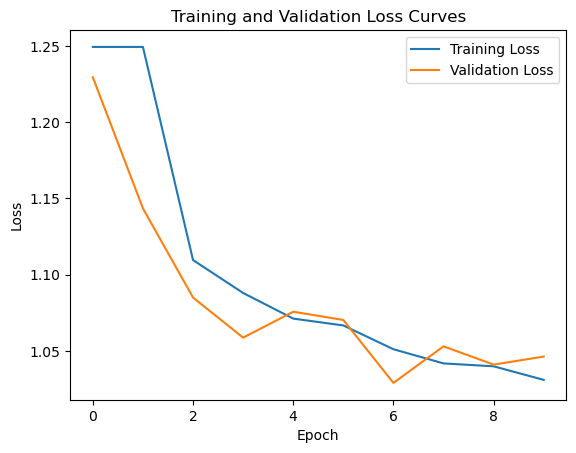

In [70]:
# Plot the losses after training
train_losses = [1.2494, 1.2494, 1.1096, 1.0880, 1.0712, 1.0667, 1.0511, 1.0418, 1.0399, 1.0310]
val_losses = [1.2295, 1.1435, 1.0850, 1.0587, 1.0757, 1.0703, 1.0290, 1.0530, 1.0410, 1.0463]


plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [75]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def compute_metrics(y_true, y_pred, classes):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes, zero_division=1))

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def display_sample_predictions(model, test_loader, device, classes, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= num_samples:
                break
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for j in range(2):
                img = images[j].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"True: {classes[labels[j]]}\nPred: {classes[preds[j]]}")
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

Accuracy: 0.5000
Precision: 0.5066
Recall: 0.5000
F1 Score: 0.6064

Classification Report:
              precision    recall  f1-score   support

  Clear Shot       1.00      0.00      0.00        16
   Lift shot       0.00      0.00      1.00        19
       Serve       1.00      0.60      0.75         5
  Smash Shot       0.49      0.97      0.65        36

    accuracy                           0.50        76
   macro avg       0.62      0.39      0.60        76
weighted avg       0.51      0.50      0.61        76



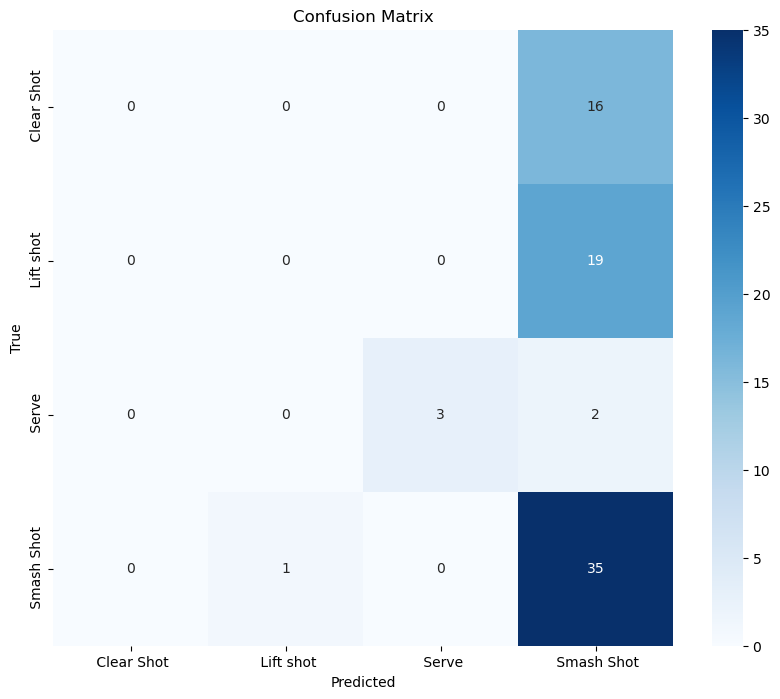

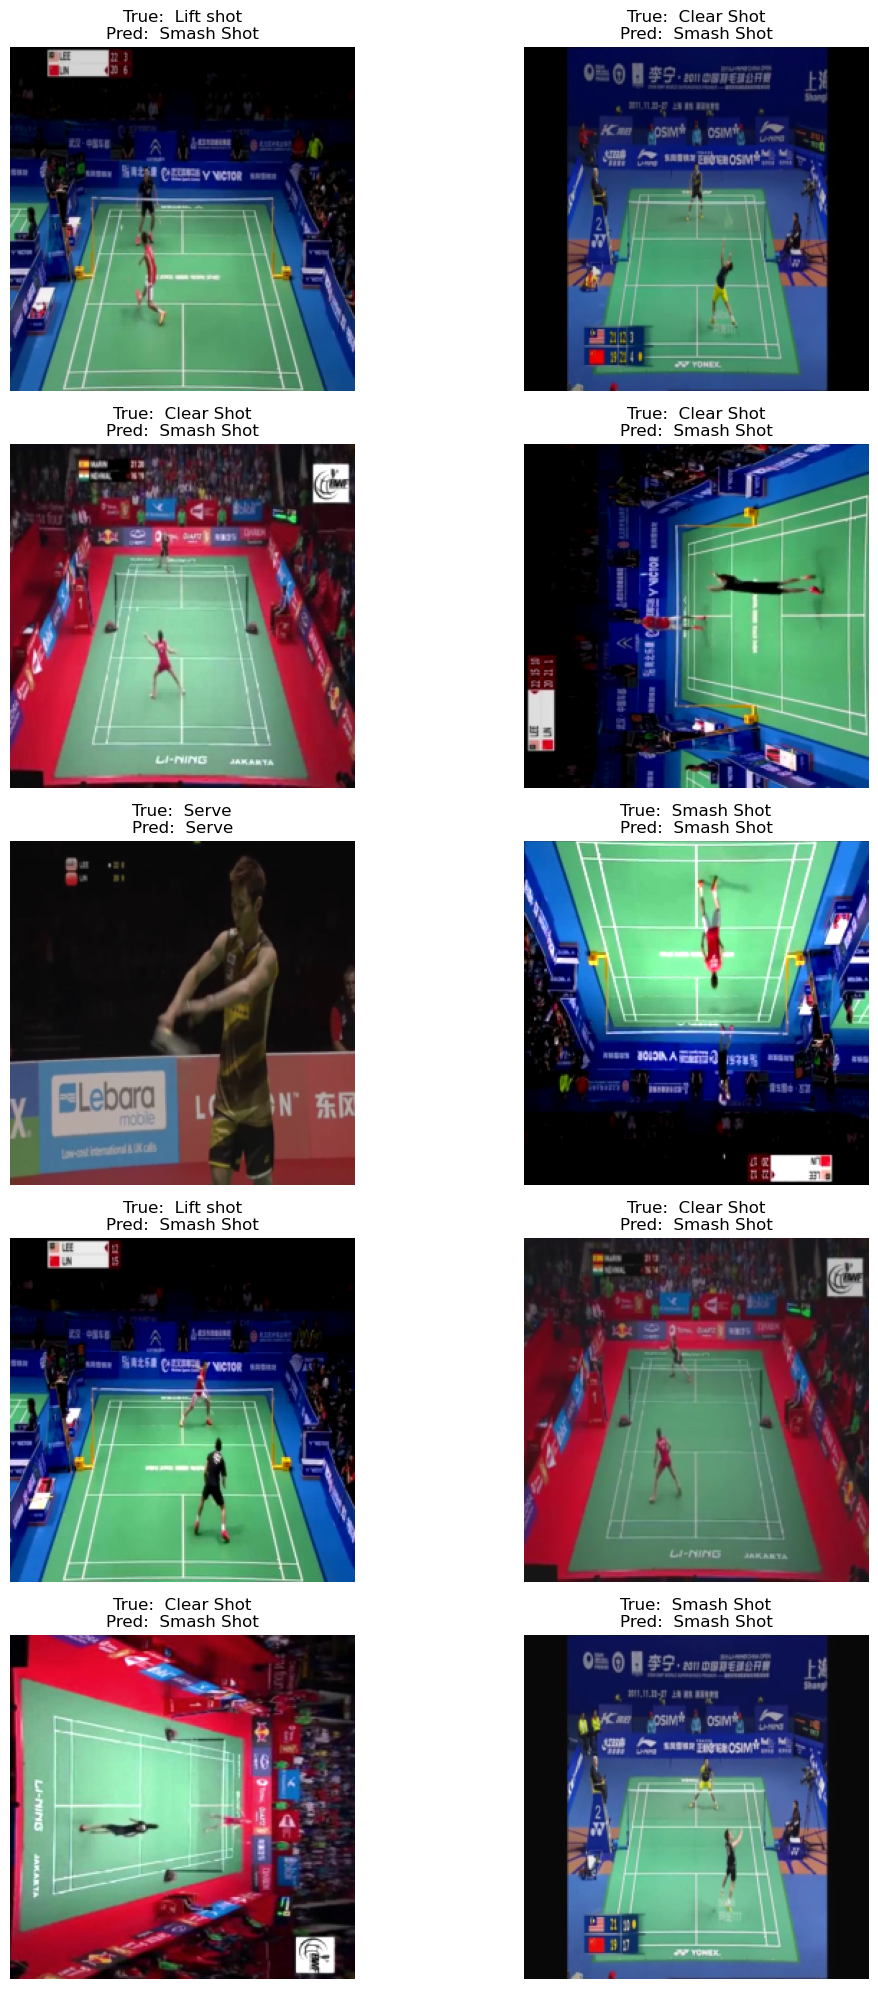

In [79]:
# Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

y_pred, y_true = evaluate_model(model, test_loader, device)

# Compute and display metrics
compute_metrics(y_true, y_pred, dataset.classes)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, dataset.classes)

# Display sample predictions
display_sample_predictions(model, test_loader, device, dataset.classes)

In [2]:
import torch
import torch.nn as nn

def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0.0
    num_samples = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * images.size(0)
            num_samples += images.size(0)
    
    average_loss = total_loss / num_samples
    return average_loss

In [3]:
test_error = evaluate_model(model, test_loader, devide)
print(f"Test Error (Average Loss): {test_error:.4f}")

NameError: name 'model' is not defined